## Дз 7: "Metric learning"

ФИО: Лыжин Роман Денисович

## Цель задания:
Познакомится с алгоритмами metric learning
## Описание задания:
В рамках данного домашнего задания предлагается решить задачу поиска похожего автомобиля в базе данных (автомобиля того же класса). На основе датасета [cars196](https://paperswithcode.com/sota/metric-learning-on-cars196) , ссылка на данные [мета](https://drive.google.com/file/d/1PD-lbbcKSelDeAYKafe3boc5mqqEe7X7/view?usp=sharing) [data](https://drive.google.com/file/d/1l9EnYMC-xGX706SY1kN8RceMmFViASfx/view?usp=sharing).

Процесс выполнения задания следующий:

0. Выбор модели эмбеддера:
    1. Выберите модель кодирующую изображения для выполнения домашнего задания. Любую, кроме модели resnet50.

1. Подготовка обучающего набора данных
    1. Реализуйте корректный класс Dataset и Dataloader для выбранной модели (должен работать форвард вашей модели на том, что выходит из даталоадера).
    2. Добавьте аугментации в датасет **0.5 балла**.

2. Реализация корректного train-loop и обучение модели:  
    1. Реализуйте train-loop для вашей модели и проведите обучение c Triplet loss **2 балла**.
    2. При формировании триплета не просто брать отрицательный класс, а воспользоваться техникой hard negative mining **0.5 балла**.
    3. Обучите модель и воcпользуйте иными loss функциями для задачи metric learning **0.5 балла**.
    4. Полезные ссылки [тык](https://github.com/KevinMusgrave/pytorch-metric-learning)

3. Валидация обученных моделей на тестовой выборке, вычисление метрики Recall и Precision
    1. Оцените качество моделей на тестовой части данных и рассчитайте метрики поиска Recall@1, Recall@5, Precision@1, Precision@5. Обратите внимание, что для формирования предсказаний на тестовой выборке вы не должны предсказывать напрямую класс объекта, а должны производить поиск на основе получившихся эмбеддингов (пример в [семинаре](metric_learning.ipynb) блок Faiss). **0.5 балла**
    2. При поиске воспользоваться библиотекой Faiss **0.5 балла**

4. Выводы:
    1. Проанализируйте результаты обучения, визуально оцените качество работы модели.
    2. Прокомментируйте распространенные ошибки модели и предложите пути для улучшения финального решения.
    3. Проинтерпретируйте результаты работы модели с помощью [GradCam](https://github.com/jacobgil/pytorch-grad-cam)  **0.5 балла**

## Срок выполнения задания:
Данное задание можно сдать без штрафов до 18 марта.


In [ ]:
!pip install pytorch_metric_learning faiss-gpu
!pip install git+https://github.com/jacobgil/pytorch-grad-cam

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 120.2/120.2 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 11.9 MB/s eta 0:00:00


In [ ]:
import gdown
import os
from scipy.io import loadmat
import pandas as pd
from torchvision import models, transforms
import torch
import torch.nn as nn
from pytorch_metric_learning import losses, miners
from torch import optim
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import faiss
import numpy as np

## Скачивание файлов

In [ ]:
# Ссылки на файлы
devkit_url = "https://drive.google.com/file/d/1PD-lbbcKSelDeAYKafe3boc5mqqEe7X7/view?usp=sharing"
archive_url = "https://drive.google.com/file/d/1l9EnYMC-xGX706SY1kN8RceMmFViASfx/view?usp=sharing"

# Загрузка файлов
gdown.download(devkit_url, "devkit.zip", fuzzy=True)
gdown.download(archive_url, "archive.zip", fuzzy=True)

Downloading...
From: https://drive.google.com/uc?id=1PD-lbbcKSelDeAYKafe3boc5mqqEe7X7
To: /content/devkit.zip
100%|██████████| 332k/332k [00:00<00:00, 84.3MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1l9EnYMC-xGX706SY1kN8RceMmFViASfx
From (redirected): https://drive.google.com/uc?id=1l9EnYMC-xGX706SY1kN8RceMmFViASfx&confirm=t&uuid=b79e558a-1a27-4cc0-b8dd-fccddae9466d
To: /content/archive.zip
100%|██████████| 1.96G/1.96G [00:52<00:00, 37.3MB/s]


'archive.zip'

In [ ]:
!unzip -q devkit.zip -d devkit
!unzip -q archive.zip -d archive

In [ ]:
devkit_path = "devkit/devkit"
data_path = "archive"

train_annos = loadmat(os.path.join(devkit_path, "cars_train_annos.mat"))["annotations"][0]
test_annos = loadmat(os.path.join(devkit_path, "cars_test_annos.mat"))["annotations"][0]
meta = loadmat(os.path.join(devkit_path, "cars_meta.mat"))["class_names"][0]

train_data = []
for item in train_annos:
    train_data.append({
        "image_path": os.path.join(data_path, "cars_train/cars_train", item[5][0]),
        "class_id": item[4][0][0] - 1,
        "bbox": [item[0][0][0], item[1][0][0], item[2][0][0], item[3][0][0]]  # (x1, x2, y1, y2)
    })

train_df = pd.DataFrame(train_data)

test_data = []
for item in test_annos:
    test_data.append({
        "image_path": os.path.join(data_path, "cars_test/cars_test", item[4][0]),
        "bbox": [item[0][0][0], item[1][0][0], item[2][0][0], item[3][0][0]]
    })

test_df = pd.DataFrame(test_data)

train_df.to_csv("train.csv", index=False)
test_df.to_csv("test.csv", index=False)


In [ ]:
train_df.head()

image_path  class_id                    bbox
0  archive/cars_train/cars_train/00001.jpg        13     [39, 116, 569, 375]
1  archive/cars_train/cars_train/00002.jpg         2     [36, 116, 868, 587]
2  archive/cars_train/cars_train/00003.jpg        90     [85, 109, 601, 381]
3  archive/cars_train/cars_train/00004.jpg       133  [621, 393, 1484, 1096]
4  archive/cars_train/cars_train/00005.jpg       105       [14, 36, 133, 99]

In [ ]:
test_df.head()

image_path                  bbox
0  archive/cars_test/cars_test/00001.jpg    [30, 52, 246, 147]
1  archive/cars_test/cars_test/00002.jpg   [100, 19, 576, 203]
2  archive/cars_test/cars_test/00003.jpg   [51, 105, 968, 659]
3  archive/cars_test/cars_test/00004.jpg    [67, 84, 581, 407]
4  archive/cars_test/cars_test/00005.jpg  [140, 151, 593, 339]

In [ ]:
train_df.shape

(8144, 3)

## Подготовка Dataset, DataLoader

In [53]:
import os
import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T

class CarsDataset(Dataset):
    def __init__(self, dataframe, transform=None, original_transform=None, include_labels=True):
        self.dataframe = dataframe
        self.transform = transform
        self.original_transform = original_transform
        self.include_labels = include_labels

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        image = Image.open(row["image_path"]).convert("RGB")

        if self.original_transform:
            original_image = self.original_transform(image)

        if self.transform:
            image = self.transform(image)

        if self.include_labels:
            label = row["class_id"]
            return image, label, original_image
        else:
            return image, original_image

train_transform = T.Compose([
    T.RandomResizedCrop(224),
    T.RandomHorizontalFlip(),
    T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

original_transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor()
])

train_data, val_data = train_test_split(
    train_df,
    test_size=0.2,
    stratify=train_df["class_id"],
    random_state=42
)

train_data = pd.DataFrame(train_data)
val_data = pd.DataFrame(val_data)

train_dataset = CarsDataset(train_data, transform=train_transform, include_labels=True)
val_dataset = CarsDataset(val_data, transform=test_transform, include_labels=True)
test_dataset = CarsDataset(test_df, transform=test_transform, original_transform = original_transform, include_labels=False)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=0)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


## Инициализация модели и эмбеддера

In [ ]:
class Embedder(nn.Module):
    def __init__(self, backbone, embedding_dim):
        super(Embedder, self).__init__()
        self.backbone = backbone
        self.pooling = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(1280, embedding_dim)
        self.bn = nn.BatchNorm1d(embedding_dim)

    def forward(self, x):
        x = self.backbone(x)
        x = self.pooling(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        x = self.bn(x)
        x = nn.functional.normalize(x, p=2, dim=1)
        return x

In [33]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_features = models.efficientnet_b0(pretrained=True).features #backbone
embedding_dim = 32
embedder = Embedder(model_features, embedding_dim).to(device)

optimizer = torch.optim.AdamW(embedder.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
device

device(type='cuda')

## Обучение и валидация модели

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from pytorch_metric_learning import miners, losses
from tqdm import tqdm

# Используем TripletMarginMiner для hard negative mining
triplet_loss = losses.TripletMarginLoss(margin=0.2)
miner = miners.TripletMarginMiner(margin=0.2, type_of_triplets="hard")

In [ ]:
import faiss
import numpy as np
import torch

def save_checkpoint(checkpoint, filename):
    torch.save(checkpoint, filename)

def validate_model(model, val_loader, metric_fn, device):
    model.eval()
    all_embeddings = []
    all_labels = []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            embeddings = model(images)
            all_embeddings.append(embeddings.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    all_embeddings = np.vstack(all_embeddings)
    all_labels = np.hstack(all_labels)

    metrics = metric_fn(all_embeddings, all_labels)
    return metrics

def calculate_metrics(embeddings, labels):
    index = faiss.IndexFlatL2(embeddings.shape[1])
    index.add(embeddings)
    k = 5
    distances, indices = index.search(embeddings, k)

    recall_at_1 = 0
    recall_at_5 = 0
    precision_at_1 = 0
    precision_at_5 = 0
    num_samples = len(labels)

    for i in range(num_samples):
        retrieved_labels = labels[indices[i]]
        relevant_retrieved = (retrieved_labels == labels[i]).astype(int)

        recall_at_1 += relevant_retrieved[:1].sum()
        recall_at_5 += relevant_retrieved[:5].sum()
        precision_at_1 += relevant_retrieved[:1].mean()
        precision_at_5 += relevant_retrieved[:5].mean()

    recall_at_1 /= num_samples
    recall_at_5 /= num_samples
    precision_at_1 /= num_samples
    precision_at_5 /= num_samples

    return {
        'Recall@1': recall_at_1,
        'Recall@5': recall_at_5,
        'Precision@1': precision_at_1,
        'Precision@5': precision_at_5
    }

def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, miner, num_epochs=10):
    device = next(model.parameters()).device
    best_val_loss = float('inf')
    best_model_weights = None
    train_losses, val_losses = [], []
    val_metrics_history = []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0

        for images, labels in tqdm(train_loader):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            embeddings = model(images)

            hard_pairs = miner(embeddings, labels)
            loss = criterion(embeddings, labels, hard_pairs)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        val_metrics = validate_model(model, val_loader, calculate_metrics, device)
        val_loss = val_metrics['Recall@1']
        val_losses.append(val_loss)
        val_metrics_history.append(val_metrics)

        scheduler.step(val_loss)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_weights = model.state_dict().copy()
            checkpoint = {
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': val_loss,
            }
            save_checkpoint(checkpoint, 'best_checkpoint.pth')

        print(f'Epoch {epoch+1}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}, Metrics = {val_metrics}')

    if best_model_weights:
        model.load_state_dict(best_model_weights)

    return model, train_losses, val_losses, val_metrics_history


In [ ]:
trained_model, train_losses, val_losses, val_metrics_history = train_model(
    model=embedder,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=triplet_loss,
    optimizer=optimizer,
    scheduler=scheduler,
    miner=miner,
    num_epochs=10
)

100%|██████████| 408/408 [01:46<00:00,  3.83it/s]
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Epoch 1: Train Loss = 0.2213, Val Loss = 1.0000, Metrics = {'Recall@1': 1.0, 'Recall@5': 1.0202578268876612, 'Precision@1': 1.0, 'Precision@5': 0.20405156537752603}


100%|██████████| 408/408 [01:32<00:00,  4.42it/s]


Epoch 2: Train Loss = 0.2204, Val Loss = 1.0000, Metrics = {'Recall@1': 1.0, 'Recall@5': 1.028852056476366, 'Precision@1': 1.0, 'Precision@5': 0.20577041129526702}


100%|██████████| 408/408 [01:34<00:00,  4.30it/s]


Epoch 3: Train Loss = 0.2230, Val Loss = 1.0000, Metrics = {'Recall@1': 1.0, 'Recall@5': 1.0202578268876612, 'Precision@1': 1.0, 'Precision@5': 0.204051565377526}


100%|██████████| 408/408 [01:35<00:00,  4.28it/s]


Epoch 4: Train Loss = 0.2103, Val Loss = 1.0000, Metrics = {'Recall@1': 1.0, 'Recall@5': 1.01841620626151, 'Precision@1': 1.0, 'Precision@5': 0.2036832412522958}


100%|██████████| 408/408 [01:34<00:00,  4.32it/s]


Epoch 5: Train Loss = 0.2300, Val Loss = 1.0000, Metrics = {'Recall@1': 1.0, 'Recall@5': 1.0202578268876612, 'Precision@1': 1.0, 'Precision@5': 0.20405156537752603}


100%|██████████| 408/408 [01:30<00:00,  4.52it/s]


Epoch 6: Train Loss = 0.1942, Val Loss = 0.9994, Metrics = {'Recall@1': 0.9993861264579497, 'Recall@5': 1.0233271945979128, 'Precision@1': 0.9993861264579497, 'Precision@5': 0.20466543891957642}


100%|██████████| 408/408 [01:34<00:00,  4.31it/s]


Epoch 7: Train Loss = 0.1869, Val Loss = 1.0000, Metrics = {'Recall@1': 1.0, 'Recall@5': 1.0263965623081646, 'Precision@1': 1.0, 'Precision@5': 0.2052793124616268}


100%|██████████| 408/408 [01:32<00:00,  4.40it/s]


Epoch 8: Train Loss = 0.2103, Val Loss = 1.0000, Metrics = {'Recall@1': 1.0, 'Recall@5': 1.0208717004297114, 'Precision@1': 1.0, 'Precision@5': 0.20417434008593613}


100%|██████████| 408/408 [01:30<00:00,  4.50it/s]


Epoch 9: Train Loss = 0.1980, Val Loss = 1.0000, Metrics = {'Recall@1': 1.0, 'Recall@5': 1.0245549416820134, 'Precision@1': 1.0, 'Precision@5': 0.20491098833639668}


100%|██████████| 408/408 [01:38<00:00,  4.16it/s]


Epoch 10: Train Loss = 0.2257, Val Loss = 1.0000, Metrics = {'Recall@1': 1.0, 'Recall@5': 1.0214855739717619, 'Precision@1': 1.0, 'Precision@5': 0.2042971147943462}


## Визуализация на тестовой выборке

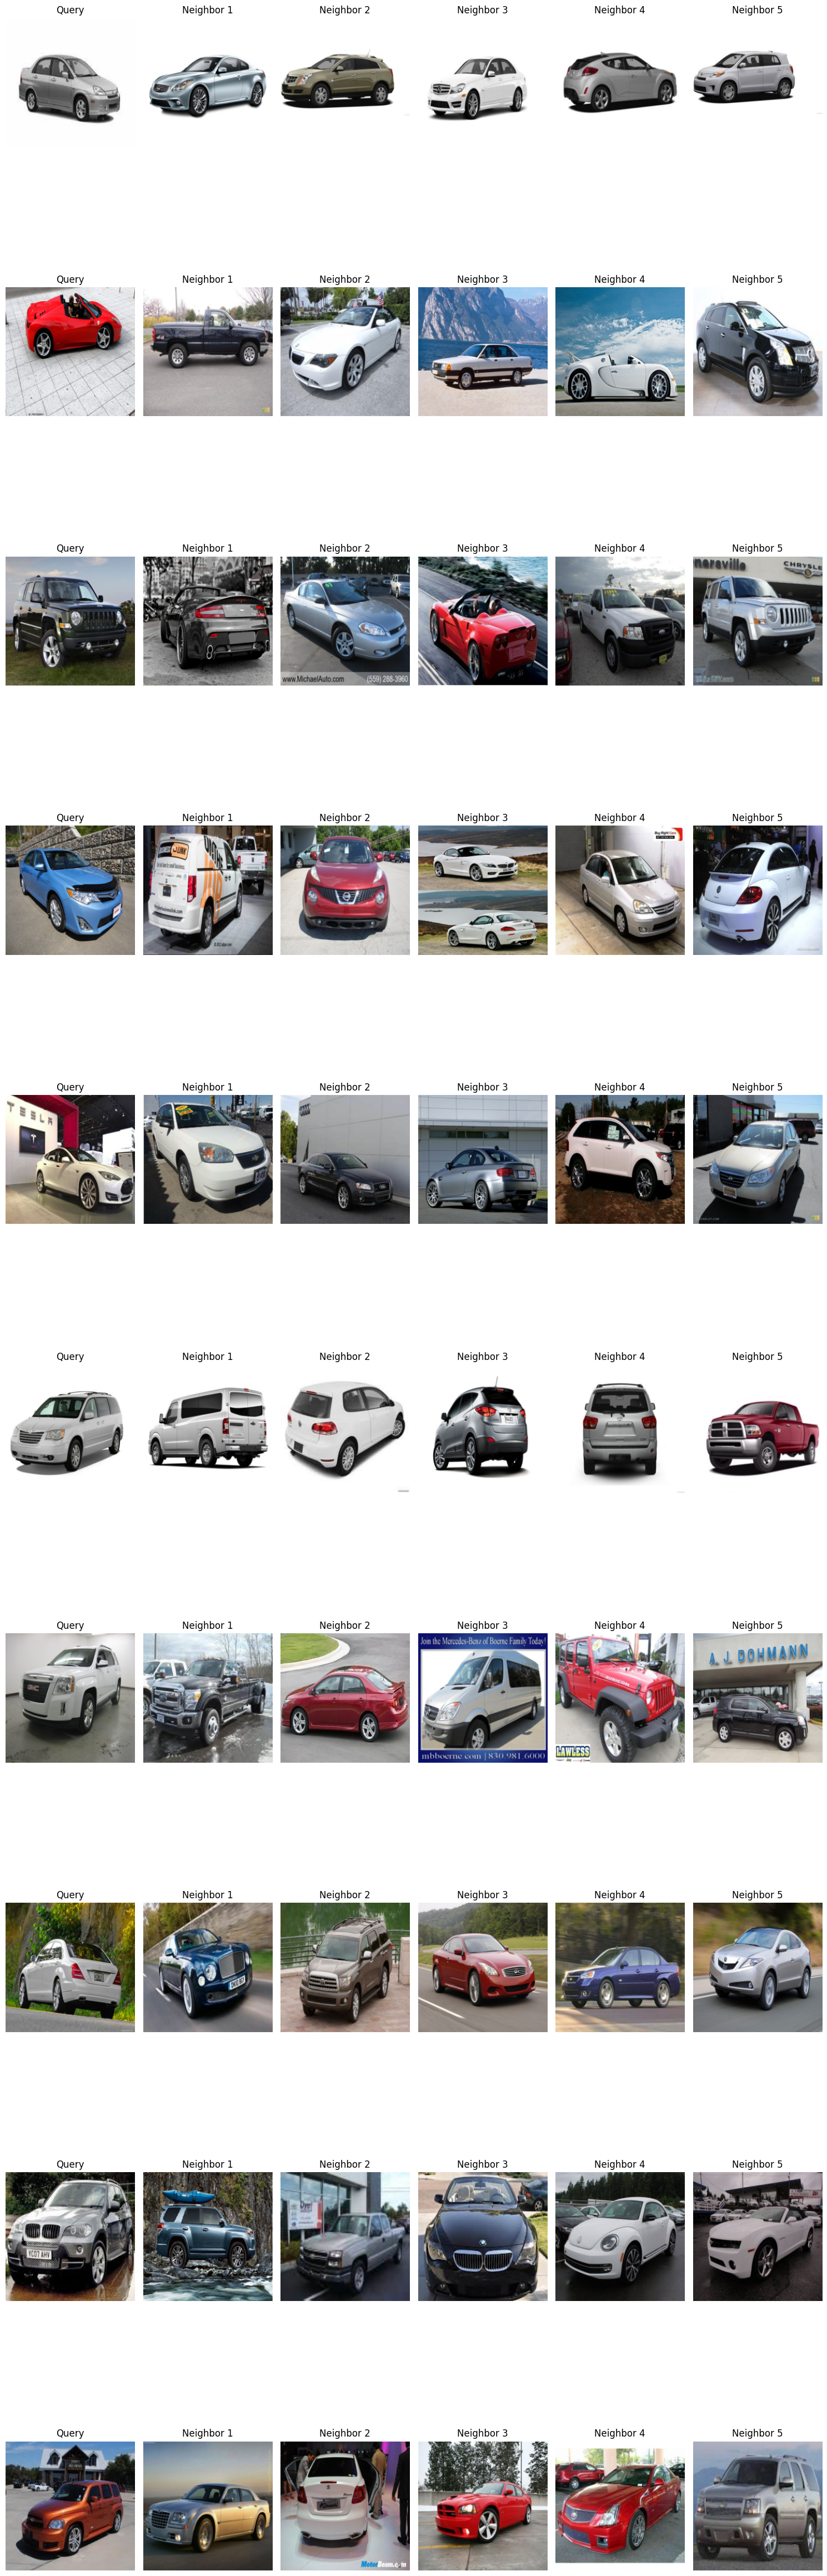

In [ ]:
import faiss
import torch
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image

def predict_test_embeddings_with_originals(trained_model, test_loader):
    device = next(trained_model.parameters()).device
    trained_model.eval()
    embeddings_list, originals_list = [], []
    with torch.no_grad():
        for images, originals in test_loader:
            images = images.to(device)
            embeddings = trained_model(images)
            embeddings_list.append(embeddings.cpu())
            originals_list.extend(originals)
    return torch.cat(embeddings_list), originals_list

def find_nearest_neighbors(embeddings, k=6):
    index = faiss.IndexFlatL2(embeddings.size(1))
    index.add(embeddings.numpy())
    distances, indices = index.search(embeddings.numpy(), k)

    filtered_indices = []
    for i, neighbors in enumerate(indices):
        filtered_indices.append([idx for idx in neighbors if idx != i][:k - 1])
    return distances, torch.tensor(filtered_indices)

def visualize_neighbors(images, indices, num_samples=10):
    num_samples = min(num_samples, len(images))
    plt.figure(figsize=(15, 5 * num_samples))

    for i in range(num_samples):

        plt.subplot(num_samples, 6, i * 6 + 1)
        plt.imshow(to_pil_image(images[i].cpu()))
        plt.title("Query")
        plt.axis('off')


        for j in range(5):
            plt.subplot(num_samples, 6, i * 6 + 2 + j)
            plt.imshow(to_pil_image(images[indices[i, j]].cpu()))
            plt.title(f"Neighbor {j+1}")
            plt.axis('off')

    plt.tight_layout()
    plt.show()

test_embeddings, test_images = predict_test_embeddings_with_originals(trained_model, test_loader)

_, nearest_indices = find_nearest_neighbors(test_embeddings)

visualize_neighbors(test_images, nearest_indices, num_samples=10)


Вывод: Как можно заметить, качество работы модели среднее. Есть много случаев, когда в качестве ближайших соседей выбираются машины других марок. Решение можно улучшить, выбрав другую технику майнинга, а также добавить аугментаций. При использовании hard negative mining модели сложно разделять классы.

## GradCAM

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py:1827: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


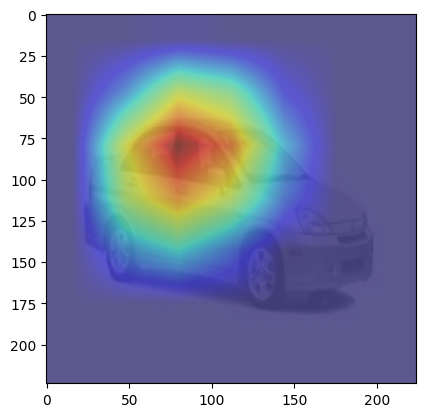

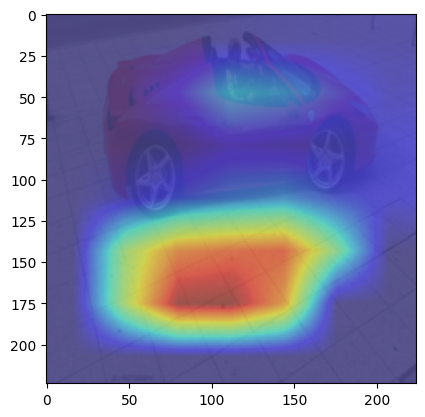

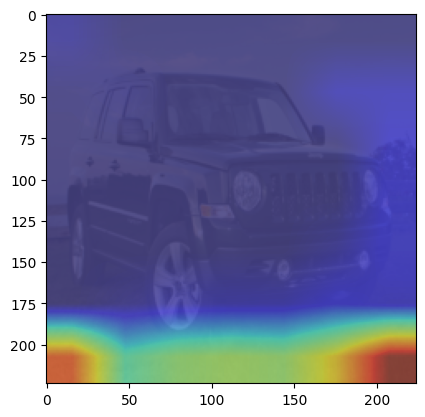

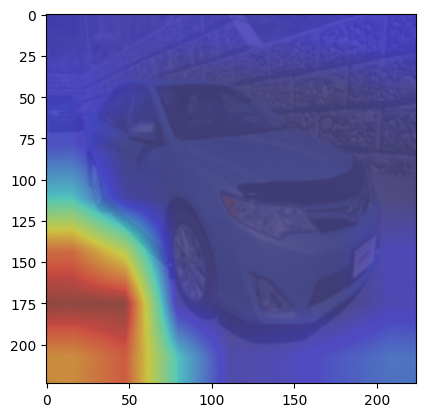

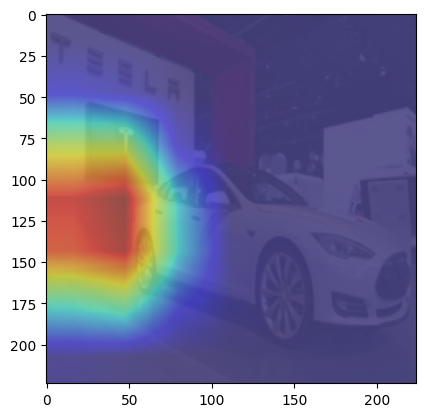

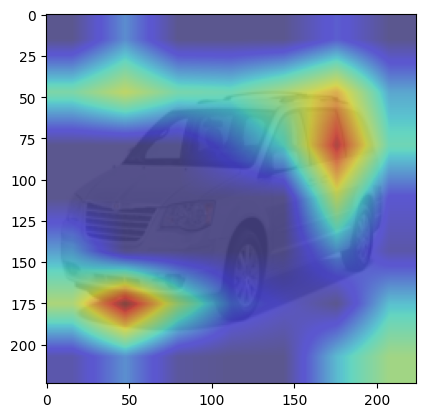

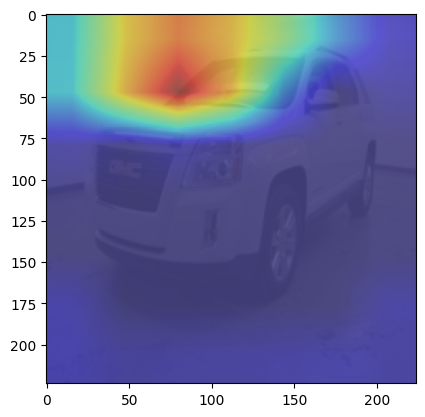

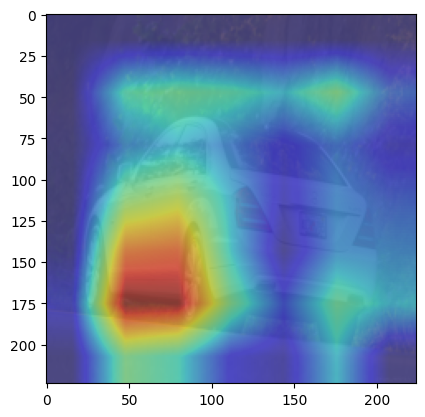

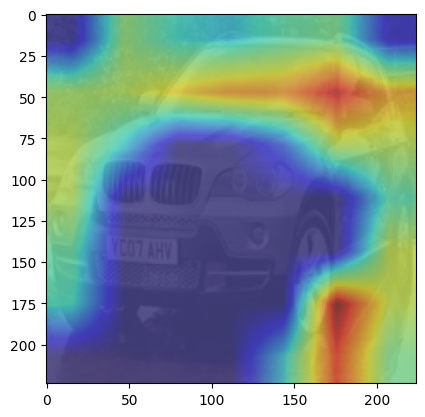

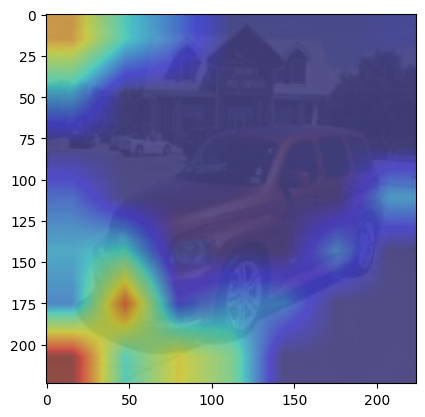

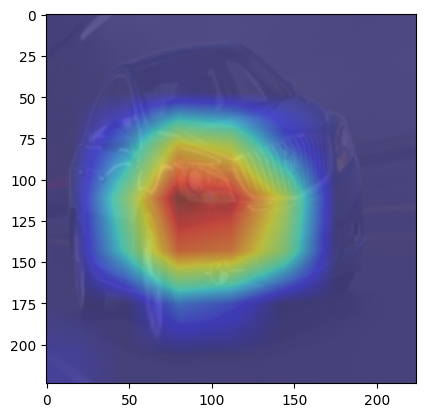

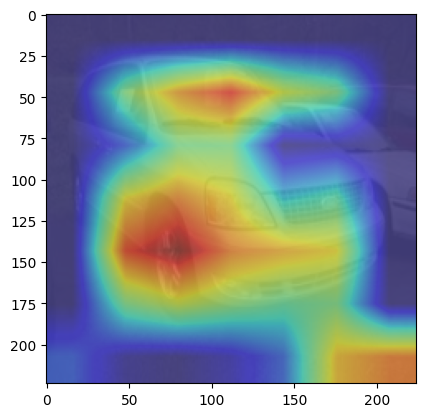

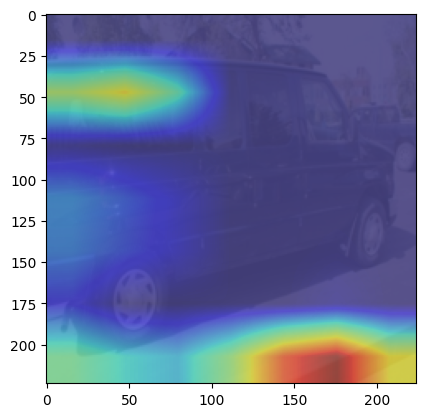

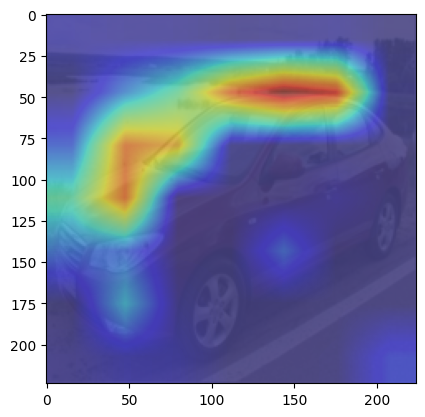

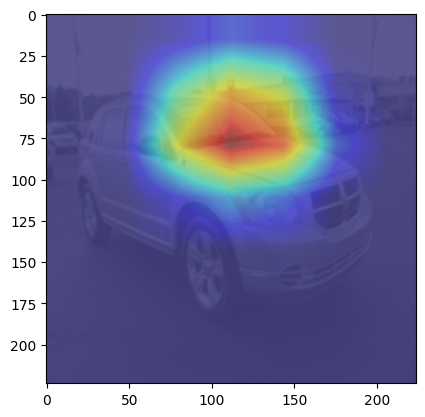

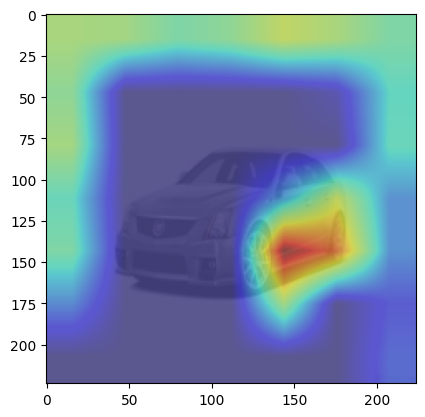

In [88]:
import os
import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import torch
import torch.nn as nn
import torchvision.models as models
from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

target_layers = [trained_model.backbone[-1]]
grad_cam = GradCAM(model=trained_model, target_layers=target_layers)

with torch.no_grad():
    for images, original_images in test_loader:
        images = images.to(device)
        original_images = original_images.to(device)
        break # 1 батч

targets = [ClassifierOutputTarget(i) for i in range(len(images))]


grayscale_cam = grad_cam(input_tensor=images, targets=targets)

for i, cam in enumerate(grayscale_cam):
    visualization = cam.squeeze()
    original_image = original_images[i].cpu().numpy().transpose(1,2,0)
    original_image = (original_image * [0.229, 0.224, 0.225]) + [0.485, 0.456, 0.406
    original_image = original_image.clip(0, 1)

    import matplotlib.pyplot as plt
    plt.imshow(original_image)
    plt.imshow(visualization, alpha=0.5, cmap='jet')
    plt.show()

GradCAM показывает, что в большом количестве случаев модель делает классификацию на основе фона, или лишь отдельных частей автомобиля. Это говорит о плохом качестве модели.